#GROWING CENTROID-POSSE PLOT

Damon Crockett, Software Studies Initiative, Qualcomm Institute, UCSD

##CENTROID DATA

In [1]:
DIR = "/Users/damoncrockett/Desktop/Rothko_images/"

In [2]:
DATA = DIR+"kmeans_centroids.csv"

In [3]:
import pandas as pd
df = pd.read_csv(DATA)

##PCA or t-SNE

In [4]:
from sklearn.decomposition import RandomizedPCA as pca
from sklearn.manifold import TSNE as tsne

pca = pca(n_components=2)
tsne = tsne(n_components=2)

X = df.as_matrix()

pca.fit(X)
tsne.fit(X)

#subspace = pd.DataFrame(pca.transform(X),columns=["x","y"])
subspace = pd.DataFrame(tsne.fit_transform(X),columns=["x","y"])

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

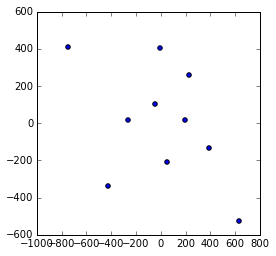

In [6]:
x = subspace.x
y = subspace.y
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x, y)

##IMAGE DATA

In [69]:
BASE = "/Users/damoncrockett/Desktop/Rothko_images/"
DATA = BASE+"hogs_clusters.csv"

In [100]:
import os
import glob

####ADD LOCAL PATHS

In [101]:
collection = pd.read_csv(DATA)
n = len(collection.index)
local_path = []
for i in range(n):
    local_path.append(BASE+os.path.basename(collection.file_names.loc[i]))
collection['local_path'] = local_path
collection.to_csv(DATA,index=False)

##GRID

In [102]:
num_bins = 25

In [103]:
# adding in some extremes to push the edges out

print subspace.x.min(), subspace.x.max(), subspace.y.min(), subspace.y.max()

-478.127092074 354.280288672 -185.641340835 181.537757376


In [104]:
x = [-500,500]
y = [-500,500]

tmp = pd.DataFrame(x,columns=["x"])
tmp["y"] = y
subspace = subspace.append(tmp)

In [105]:
subspace['x_bin'] = pd.cut(subspace['x'],num_bins,labels=False)
subspace['y_bin'] = pd.cut(subspace['y'],num_bins,labels=False)

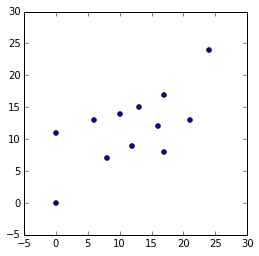

In [106]:
x = subspace.x_bin
y = subspace.y_bin
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x, y)

In [107]:
# now we can remove the extreme points we used as grid expanders

subspace = subspace[:10]

In [108]:
# now to expand the grid by simple multiplication

factor = 1

subspace["x_grid"] = subspace.x_bin * factor
subspace["y_grid"] = subspace.y_bin * factor

In [109]:
from shapely.geometry import Point

centroid_point = []
n = len(subspace.index)
for i in range(n):
    centroid_point.append(Point(subspace.x_grid.loc[i],subspace.y_grid.loc[i]))
    
subspace['centroid_point'] = centroid_point

####GRID LIST

In [110]:
grid_side = num_bins * factor

In [111]:
import numpy as np

In [112]:
x,y = range(grid_side) * grid_side, np.repeat(range(grid_side),grid_side)
grid_list = pd.DataFrame(x,columns=['x'])
grid_list['y'] = y

In [113]:
point = []
n = len(grid_list.index)
for i in range(n):
    point.append(Point(grid_list.x.loc[i],grid_list.y.loc[i]))

grid_list['point'] = point

In [114]:
open_grid = list(grid_list.point)

In [115]:
centroids = list(subspace.centroid_point)

####REMOVAL OF CENTROIDS FROM OPEN_GRID LIST

In [116]:
len(open_grid)

625

In [117]:
len(centroids)

10

In [118]:
# note that this will have the effect that, in the plot, the centroid locations will be empty

In [119]:
open_grid = [item for item in open_grid if item not in centroids]

In [120]:
len(open_grid)

615

##PLOT FUNCTION

In [121]:
from PIL import Image

In [122]:
thumb_side = 64

In [123]:
px_w = thumb_side * grid_side
px_h = thumb_side * grid_side

In [124]:
canvas = Image.new('RGB',(px_w,px_h),(50,50,50))

In [125]:
def plot():
    n = len(subspace.index)
    for i in range(n):
        centroid = subspace.centroid_point.loc[i]
        try:
            # again, a workaround for indexing difference
            candidates = collection[collection.clusters==i]
            candidates.sort("cluster_dist",inplace=True)
            best = candidates.iloc[0]
            im = Image.open(best.local_path)
            im.thumbnail((thumb_side,thumb_side),Image.ANTIALIAS)
            closest_open = min(open_grid,key=lambda x: centroid.distance(x))
            x = int(closest_open.x) * thumb_side
            y = int(closest_open.y) * thumb_side
            canvas.paste(im,(x,y))
            idx = collection[collection.local_path==best.local_path].index
            collection.drop(idx,inplace=True)
            open_grid.remove(closest_open)
            print i
        except:
            print "cluster empty"

In [126]:
iterations = list(collection.clusters.value_counts())[0]

In [1]:
#for i in range(iterations):
    #print "plot_",i
    #plot()

In [128]:
descriptor = "rothko"

In [129]:
canvas.save("/Users/damoncrockett/Desktop/entourage_plots/"+descriptor+".png")